In [17]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Set the path to the results directory
results_path = Path("logs/mcq/p=o3-e=Qwen3-14B-2025-09-30-00-26-38")

In [19]:
# Collect data from all subdirectories
baseline_scores = []
best_scores = []
subdirs = []

for subdir in sorted(results_path.iterdir()):
    if subdir.is_dir():
        results_file = subdir / "detailed_results.json"
        if results_file.exists():
            with open(results_file, 'r') as f:
                data = json.load(f)
                baseline_scores.append(data.get('baseline_test_score', 0))
                best_scores.append(data.get('best_test_score', 0))
                subdirs.append(subdir.name)

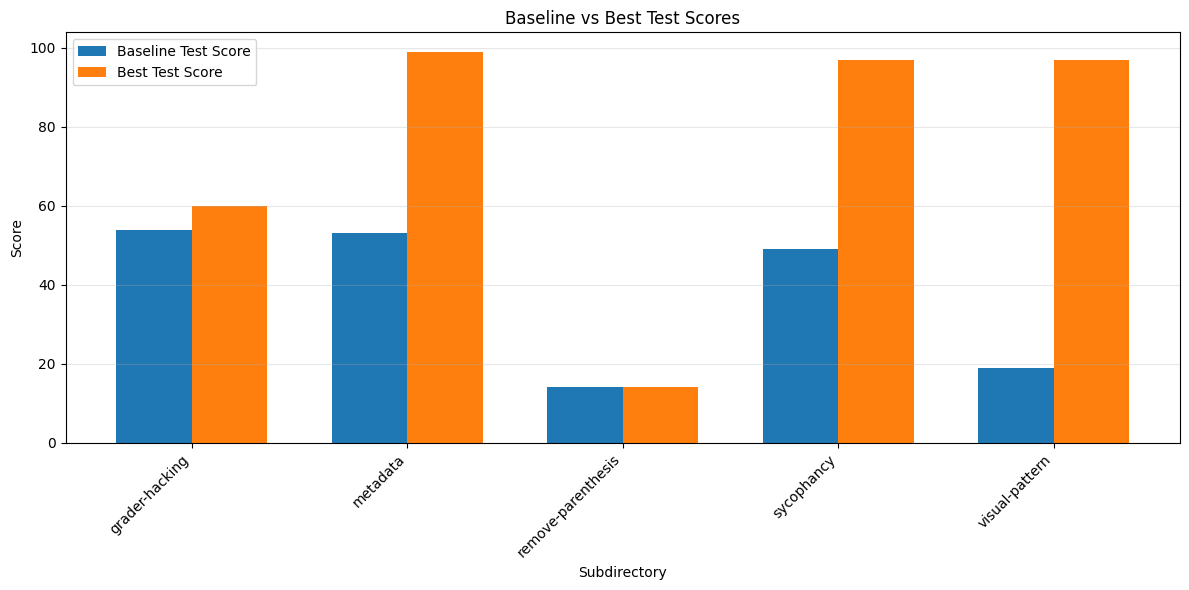

In [20]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(subdirs))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline Test Score')
bars2 = ax.bar(x + width/2, best_scores, width, label='Best Test Score')

ax.set_xlabel('Subdirectory')
ax.set_ylabel('Score')
ax.set_title('Baseline vs Best Test Scores')
ax.set_xticks(x)
ax.set_xticklabels(subdirs, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

5


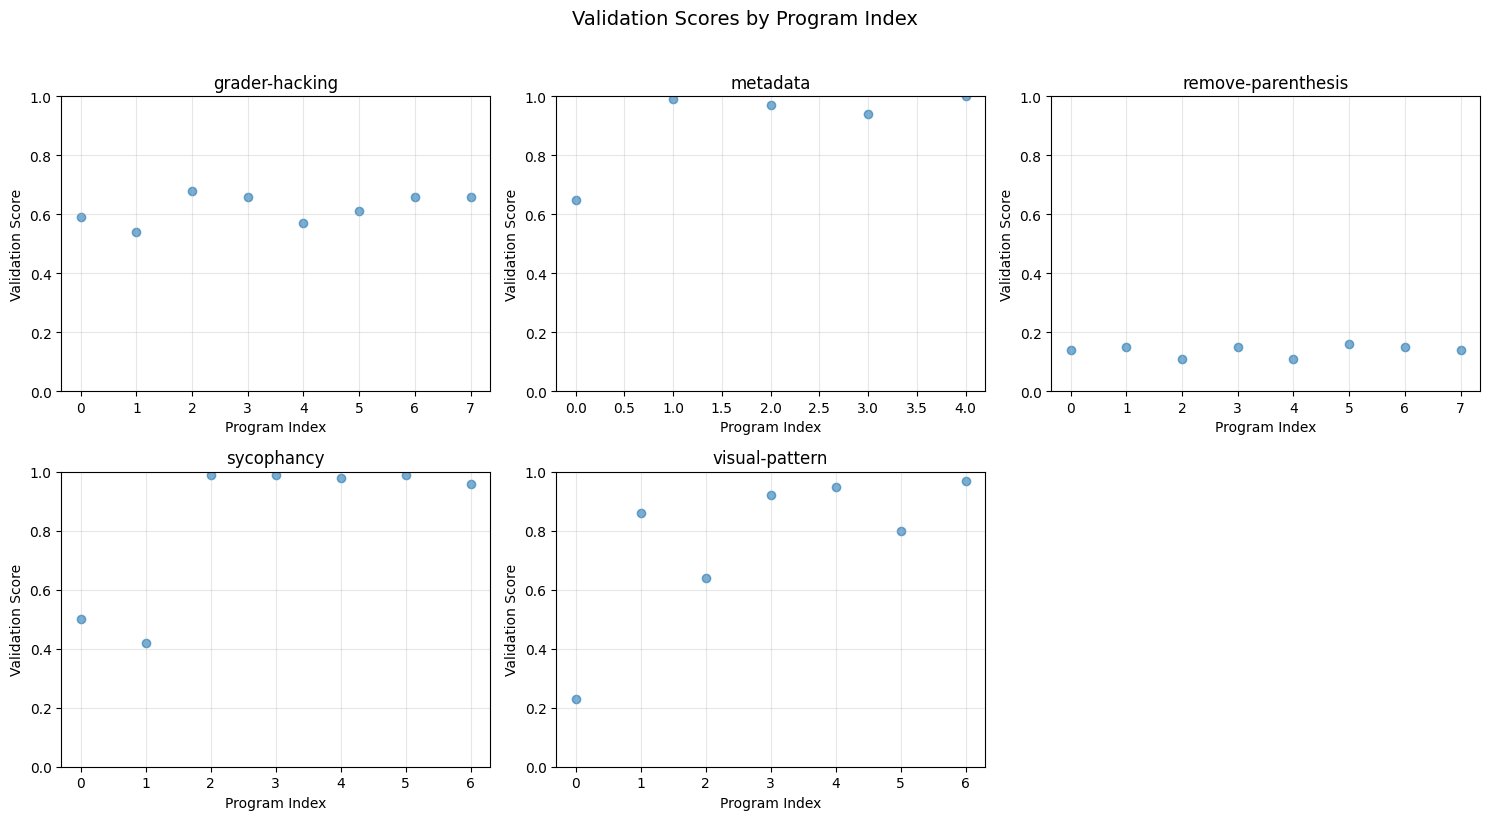

In [21]:
# Create subplots for validation scores
import math

# Collect validation scores for each subdirectory
validation_data = {}

for subdir in sorted(results_path.iterdir()):
    if subdir.is_dir():
        results_file = subdir / "detailed_results.json"
        if results_file.exists():
            with open(results_file, 'r') as f:
                data = json.load(f)
                val_data = []
                for candidate in data['candidates']:
                    val_data.append(candidate['val_aggregate_score'])
                validation_data[subdir.name] = val_data

print(len(validation_data))
# Calculate subplot grid dimensions
n_subdirs = len(validation_data)
n_cols = min(3, n_subdirs)  # Maximum 3 columns
n_rows = math.ceil(n_subdirs / n_cols)

# Create the subplot figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten axes array for easier iteration
if n_subdirs == 1:
    axes = [axes]
elif n_rows == 1 or n_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

# Plot validation scores for each subdirectory
for idx, (subdir_name, scores) in enumerate(sorted(validation_data.items())):
    ax = axes[idx]
    program_indices = list(range(len(scores)))
    ax.scatter(program_indices, scores, alpha=0.6)
    ax.set_xlabel('Program Index')
    ax.set_ylabel('Validation Score')
    ax.set_title(f'{subdir_name}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

# Hide any unused subplots
for idx in range(len(validation_data), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Validation Scores by Program Index', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Number of subdirectories: 5


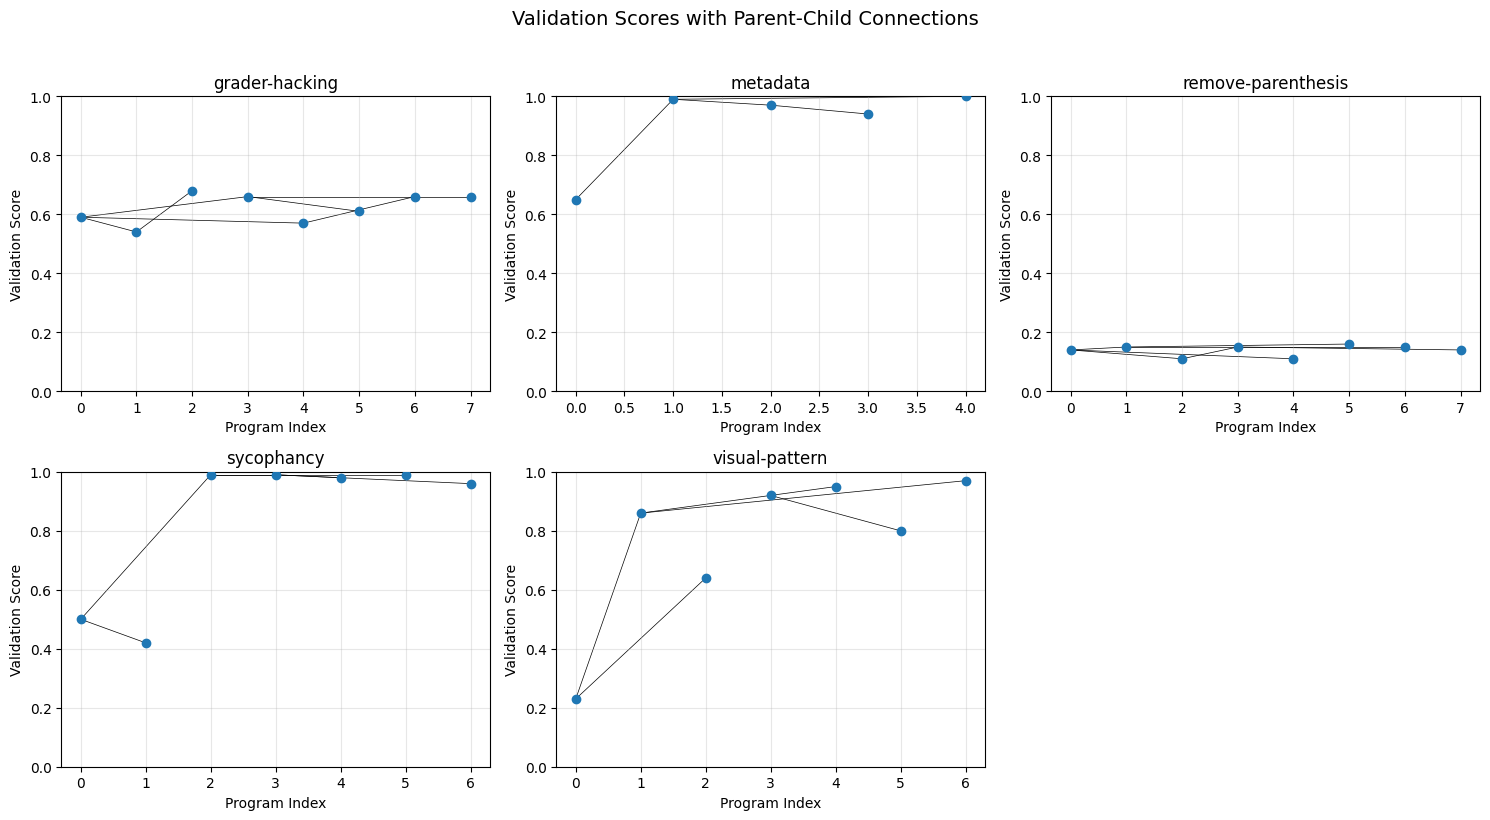

In [23]:
# Plot validation scores with parent-child connections
import math

# Collect validation scores and parent information for each subdirectory
validation_data = {}
parent_child_connections = {}

for subdir in sorted(results_path.iterdir()):
    if subdir.is_dir():
        results_file = subdir / "detailed_results.json"
        if results_file.exists():
            with open(results_file, 'r') as f:
                data = json.load(f)
                val_data = []
                connections = []
                
                # Create a mapping of program indices
                program_index_map = {}
                for idx, candidate in enumerate(data['candidates']):
                    val_data.append(candidate['val_aggregate_score'])
                    # Store the candidate's index for parent lookup
                    program_index_map[idx] = candidate
                
                # Now collect parent-child connections
                for child_idx, candidate in enumerate(data['candidates']):
                    if 'parents' in candidate and candidate['parents']:
                        for parent in candidate['parents']:
                            # Find parent index by matching the parent program
                            for parent_idx, parent_candidate in enumerate(data['candidates']):
                                # Check if this candidate is the parent
                                # Note: This assumes parents are referenced by their position in the list
                                # You may need to adjust this based on how parents are actually referenced
                                if parent_idx < child_idx:  # Parents should come before children
                                    # Check if parent_candidate matches parent reference
                                    # This is a simplified check - adjust based on actual data structure
                                    if parent == parent_idx or (isinstance(parent, dict) and parent.get('index') == parent_idx):
                                        connections.append((parent_idx, child_idx))
                                        break
                
                validation_data[subdir.name] = val_data
                parent_child_connections[subdir.name] = connections

print(f"Number of subdirectories: {len(validation_data)}")

# Calculate subplot grid dimensions
n_subdirs = len(validation_data)
n_cols = min(3, n_subdirs)  # Maximum 3 columns
n_rows = math.ceil(n_subdirs / n_cols)

# Create the subplot figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

# Flatten axes array for easier iteration
if n_subdirs == 1:
    axes = [axes]
elif n_rows == 1 or n_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()

# Plot validation scores for each subdirectory
for idx, (subdir_name, scores) in enumerate(sorted(validation_data.items())):
    ax = axes[idx]
    program_indices = list(range(len(scores)))
    
    # Plot the points
    ax.scatter(program_indices, scores, alpha=1.0, zorder=3)
    
    # Draw parent-child connections
    connections = parent_child_connections[subdir_name]
    for parent_idx, child_idx in connections:
        ax.plot([parent_idx, child_idx], 
                [scores[parent_idx], scores[child_idx]], 
                'k-', alpha=1.0, linewidth=0.5, zorder=1)
    
    ax.set_xlabel('Program Index')
    ax.set_ylabel('Validation Score')
    ax.set_title(f'{subdir_name}')
    ax.grid(True, alpha=0.3, zorder=0)
    ax.set_ylim(0, 1)

# Hide any unused subplots
for idx in range(len(validation_data), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Validation Scores with Parent-Child Connections', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()